# Attraction Basin Analysis

이 노트북은 **Unconditional Trajectory**를 기준으로 **Attraction Basin**을 탐지하는 로직을 분석하고 시각화합니다.

## Theory
Attraction Basin은 Conditional Noise와 Unconditional Noise 간의 거리(Norm Difference)가 급격하게 감소하는 구간으로 정의됩니다.

$$ \Delta_t = \| \epsilon_\theta(z_t, c) - \epsilon_\theta(z_t, \emptyset) \|_2 $$

Basin 진입 시점(Attraction Point)은 $\Delta_t$의 감소율이 최대(Gradient가 최소)인 지점으로 결정합니다:

$$ t^* = \operatorname*{argmin}_{t > t_{\text{warmup}}} (\Delta_{t+1} - \Delta_t) $$


In [5]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from diffusers import DDIMScheduler
from local_sd_pipeline import LocalStableDiffusionPipeline
import random

# Configuration
MODEL_ID = "CompVis/stable-diffusion-v1-4"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 64
NUM_STEPS = 50

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(SEED)

In [10]:
def load_prompts():
    # Memorized
    try:
        df_mem = pd.read_csv('prompts/memorized_laion_prompts.csv', sep=';')
        memorized = df_mem['Caption'].tolist()[:100]
    except Exception as e:
        print(f"Error loading memorized prompts: {e}")
        memorized = []

    # Unmemorized
    try:
        df_unmem = pd.read_csv('prompts/unmemorized_prompts.csv', sep=';')
        unmemorized = df_unmem['Caption'].tolist()[:100]
    except Exception as e:
        print(f"Error loading unmemorized prompts: {e}")
        unmemorized = []
            
    return memorized, unmemorized

memorized_prompts, unmemorized_prompts = load_prompts()
print(f"Memorized: {len(memorized_prompts)}, Unmemorized: {len(unmemorized_prompts)}")
print(memorized_prompts[:5])
print(unmemorized_prompts[:5])

Memorized: 100, Unmemorized: 100
['The No Limits Business Woman Podcast', 'Full body U-Zip main opening - Full body U-Zip main opening on front of bag for easy unloading when you get to camp', 'Mothers influence on her young hippo', '"Watch: Passion Pit\'s New Video, ""Lifted Up (1985)"""', 'Talks on the Precepts and Buddhist Ethics']
['A bridge spanning across a wide river at twilight', 'A antique clock on a mantelpiece', 'A cute cat sitting on a windowsill looking at the rain', 'An empty subway station with tiled walls and lights', 'A musician playing violin on a stage']


In [7]:
# Load Model
print("Loading pipeline...")
pipeline = LocalStableDiffusionPipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float32, 
    requires_safety_checker=False
).to(DEVICE)
pipeline.set_progress_bar_config(disable=True)

# Set Scheduler
pipeline.scheduler.set_timesteps(NUM_STEPS, device=DEVICE)
timesteps = pipeline.scheduler.timesteps

Loading pipeline...


/home/gpuadmin/cssin/init_noise_diffusion_memorization/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### 8. Pure Noise Input Analysis (Hypothesis Testing)
**가설**: Attraction Basin 안에서의 동작은 Trajectory History보다는, 해당 Time Step에서의 Noise Distribution과 관련이 있을 것이다.
이를 검증하기 위해, Trajectory를 따라가는 대신 매 Time Step마다 새로운 **Random Gaussian Noise ($z \sim \mathcal{N}(0, I)$)**를 입력으로 넣어 Norm Difference를 측정합니다.

Generating Unconditional Trajectory (Pure Noise Input)...


Uncond Trajectory: 100%|██████████| 51/51 [00:03<00:00, 14.49it/s]


Unconditional Trajectory Generated.


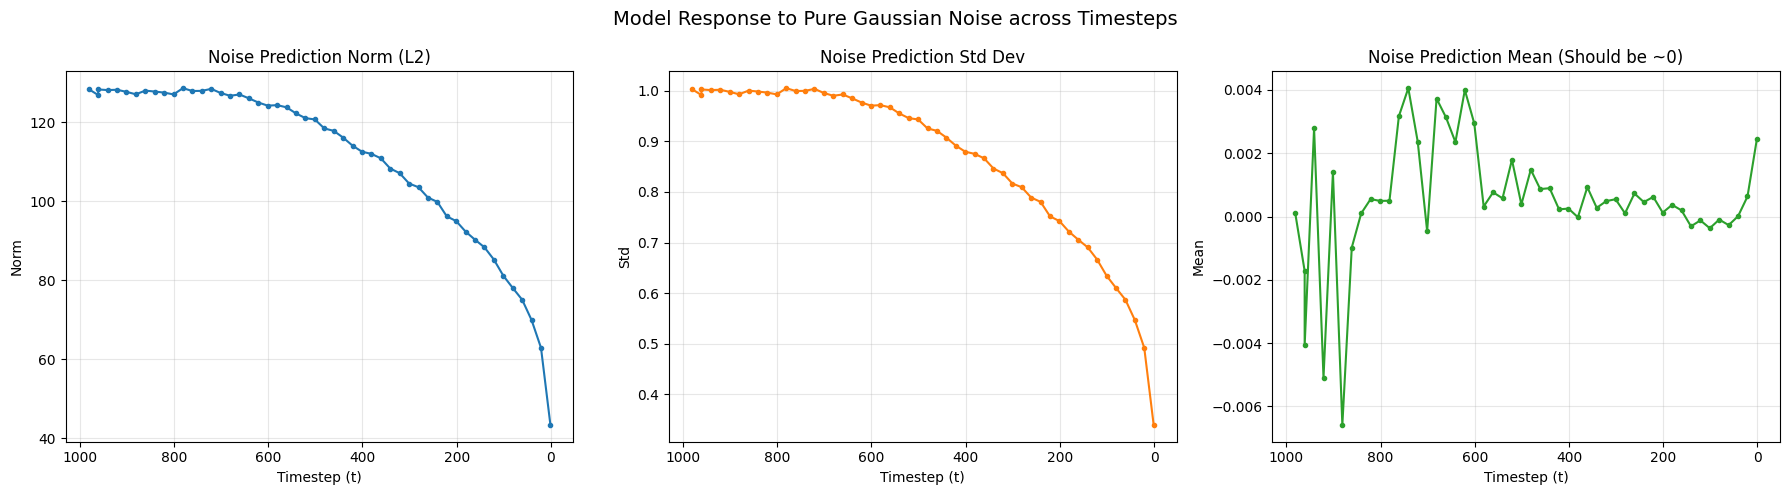

Decoding x0 predictions for visualization...


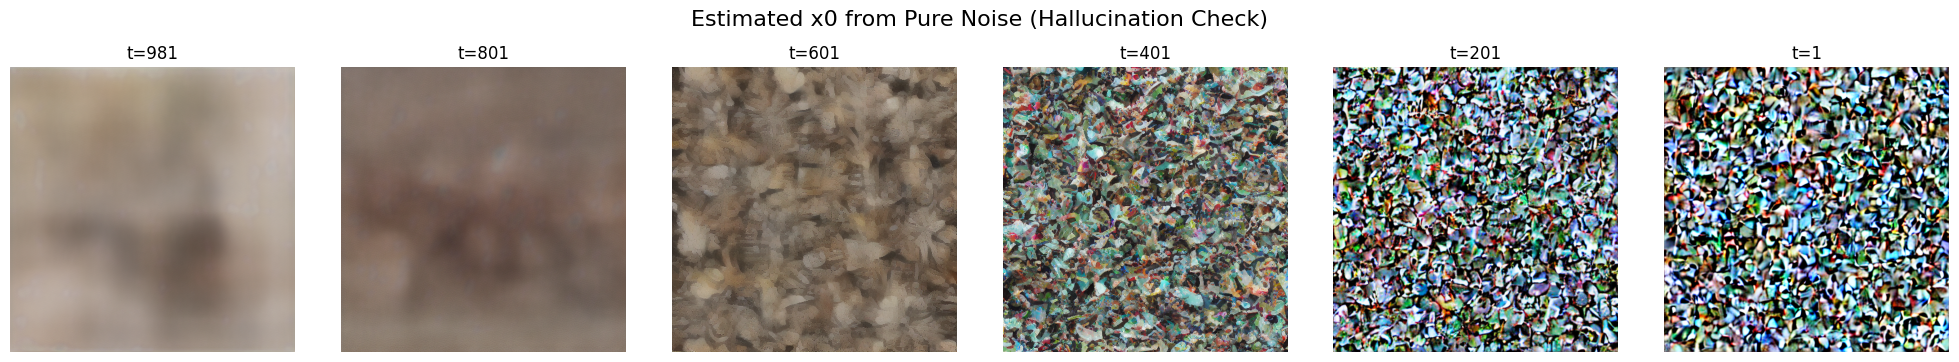

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
print("Generating Unconditional Trajectory (Pure Noise Input)...")
# 1. Setup & Generation Loop
# Null Prompt Embedding
unc_prompt_embeds = pipeline._encode_prompt("", DEVICE, 1, False, None)
generator = torch.Generator(device=DEVICE).manual_seed(SEED) 
# Calculate dimensions
height = pipeline.unet.config.sample_size * pipeline.vae_scale_factor
width = pipeline.unet.config.sample_size * pipeline.vae_scale_factor
trajectory_latents = [] 
trajectory_uncond_noise = []
trajectory_x0_preds = [] # To store x0 predictions for visualization
# Loop over timesteps
with torch.no_grad():
    curr_latents = pipeline.prepare_latents(
            1, pipeline.unet.config.in_channels, height, width,
            torch.float32, torch.device(DEVICE), generator, None
        )
    for i, t in enumerate(tqdm(timesteps, desc="Uncond Trajectory")):
        # Generate NEW Random Noise at each step (Hypothesis Testing)
        # latents: [1, 4, 64, 64]
        # Store Latents
        curr_latents = pipeline.prepare_latents(
            1, pipeline.unet.config.in_channels, height, width,
            torch.float32, torch.device(DEVICE), generator, None
        )
        trajectory_latents.append(curr_latents.clone())
        
        # Predict noise
        # Note: Do not scale input for pure noise test usually, but pipeline requires scaling
        latent_model_input = pipeline.scheduler.scale_model_input(curr_latents, t)
        noise_pred = pipeline.unet(latent_model_input, t, encoder_hidden_states=unc_prompt_embeds).sample
        
        trajectory_uncond_noise.append(noise_pred.clone())
        
        # (Optional) Calculate x0 prediction to see what model 'sees'
        # x0 = (xt - sqrt(1-alpha_bar)*eps) / sqrt(alpha_bar)
        alpha_prod_t = pipeline.scheduler.alphas_cumprod[t]
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (curr_latents - beta_prod_t ** (0.5) * noise_pred) / alpha_prod_t ** (0.5)
        
        # Save x0 pred only for specific steps to save memory (e.g., every 10 steps)
        if i % 10 == 0:
            trajectory_x0_preds.append((t.item(), pred_original_sample.clone()))
print("Unconditional Trajectory Generated.")
# 2. Visualization
# Data Preparation
steps = [t.item() for t in timesteps] # x-axis
norms = [torch.norm(n).item() for n in trajectory_uncond_noise]
stds = [torch.std(n).item() for n in trajectory_uncond_noise]
means = [torch.mean(n).item() for n in trajectory_uncond_noise]
# Plot Statistics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Plot 1: L2 Norm
axes[0].plot(steps, norms, color='tab:blue', marker='o', markersize=3)
axes[0].set_title("Noise Prediction Norm (L2)")
axes[0].set_xlabel("Timestep (t)")
axes[0].set_ylabel("Norm")
axes[0].invert_xaxis() # 1000 -> 0
axes[0].grid(True, alpha=0.3)
# Plot 2: Std Dev
axes[1].plot(steps, stds, color='tab:orange', marker='o', markersize=3)
axes[1].set_title("Noise Prediction Std Dev")
axes[1].set_xlabel("Timestep (t)")
axes[1].set_ylabel("Std")
axes[1].invert_xaxis()
axes[1].grid(True, alpha=0.3)
# Plot 3: Mean
axes[2].plot(steps, means, color='tab:green', marker='o', markersize=3)
axes[2].set_title("Noise Prediction Mean (Should be ~0)")
axes[2].set_xlabel("Timestep (t)")
axes[2].set_ylabel("Mean")
axes[2].invert_xaxis()
axes[2].grid(True, alpha=0.3)
plt.suptitle("Model Response to Pure Gaussian Noise across Timesteps", fontsize=14)
plt.tight_layout()
plt.show()
# 3. Visualize Hallucinations (x0 Predictions)
# Decode selected x0 predictions to see what the model hallucinates from pure noise
print("Decoding x0 predictions for visualization...")
n_vis = len(trajectory_x0_preds)
cols = 6
rows = (n_vis + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 3.5 * rows))
axes = axes.flatten()
for i, (t_val, lat) in enumerate(trajectory_x0_preds):
    with torch.no_grad():
        # VAE Decode
        lat_scaled = lat / pipeline.vae.config.scaling_factor
        image = pipeline.vae.decode(lat_scaled, return_dict=False)[0]
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
        
    axes[i].imshow(image)
    axes[i].set_title(f"t={t_val}")
    axes[i].axis('off')
# Hide empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.suptitle("Estimated x0 from Pure Noise (Hallucination Check)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from diffusers.models.attention_processor import Attention

# --- 1. Helper Functions & Classes (From analyze_total.py) ---

def compute_jacobian_norm(unet, latents, t, prompt_embeds, num_projections=8):
    """
    Hutchinson estimator for ||J||_F where J = d epsilon_theta(latents, t, c) / d c.

    Uses: E_v [ ||J^T v||^2 ] = ||J||_F^2 for v ~ N(0, I).
    Returns sqrt(mean(||J^T v||^2)) ≈ ||J||_F.
    """
    if num_projections < 1:
        raise ValueError("num_projections must be >= 1")

    prompt_embeds = prompt_embeds.detach()
    latents = latents.detach()

    with torch.enable_grad():
        prompt_embeds.requires_grad_(True)

        # Forward once (graph kept) so we can do multiple VJP probes cheaply
        noise_pred = unet(latents, t, encoder_hidden_states=prompt_embeds).sample

        sq_norm_sum = 0.0
        for k in range(num_projections):
            # Random probe in output space
            v = torch.randn_like(noise_pred)

            # <epsilon, v>
            v_dot_eps = (noise_pred * v).sum()

            # grads = d/dc <epsilon, v> = J^T v
            grads = torch.autograd.grad(
                v_dot_eps,
                prompt_embeds,
                retain_graph=(k < num_projections - 1),
                create_graph=False,
            )[0]

            # Accumulate ||J^T v||^2
            sq_norm_sum += grads.pow(2).sum().detach()

        # Hutchinson estimate of ||J||_F^2
        est_frob_sq = sq_norm_sum / float(num_projections)

        # Return ||J||_F
        return est_frob_sq.sqrt().item()


class CaptureAttnMapProcessor:
    def __init__(self, store, layer_name):
        self.store = store
        self.layer_name = layer_name

    def __call__(
        self,
        attn: Attention,
        hidden_states: torch.Tensor,
        encoder_hidden_states: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
        temb: torch.Tensor = None,
        scale: float = 1.0,
    ) -> torch.Tensor:
        
        batch_size, sequence_length, _ = hidden_states.shape
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)
        query = attn.to_q(hidden_states)
        
        if encoder_hidden_states is None: encoder_hidden_states = hidden_states
        elif attn.norm_cross: encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)
        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_scores = attn.scale * torch.bmm(query, key.transpose(-1, -2))
        if attention_mask is not None: attention_scores = attention_scores + attention_mask
        attention_probs = attention_scores.softmax(dim=-1)
        
        # Save Attention Map (Averaged over heads/batch)
        if self.store.active:
            true_batch_size = hidden_states.shape[0]
            # [Batch*Heads, Q, K] -> [Batch, Heads, Q, K]
            probs_reshaped = attention_probs.view(true_batch_size, -1, attention_probs.shape[1], attention_probs.shape[2])
            # Average over heads
            avg_probs = probs_reshaped.mean(dim=1)
            # Save the map for this layer
            self.store.save_map(self.layer_name, avg_probs[0].detach().cpu())
        
        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)
        hidden_states = attn.to_out[0](hidden_states)
        hidden_states = attn.to_out[1](hidden_states)
        return hidden_states

class AttentionDataStore:
    def __init__(self):
        self.records = {} # {layer_name: [map_t0, map_t1, ...]}
        self.layer_names = []
        self.active = False
        
    def save_map(self, layer_name, attn_map):
        if layer_name not in self.records:
            self.records[layer_name] = []
            self.layer_names.append(layer_name)
        self.records[layer_name].append(attn_map)
        
    def reset(self):
        self.records = {}
        self.active = False

def setup_hooks(pipe, store):
    def register_recursive(module, name_prefix):
        for name, child in module.named_children():
            full_name = f"{name_prefix}.{name}" if name_prefix else name
            # Hook into Cross Attention layers
            is_cross = 'attn2' in name and isinstance(child, Attention)
            if is_cross:
                processor = CaptureAttnMapProcessor(store, full_name)
                child.set_processor(processor)
            else:
                register_recursive(child, full_name)
    register_recursive(pipe.unet, "")
    store.layer_names = sorted(store.layer_names)


# --- 2. Main Analysis Function ---

def analyze_attraction_basin(prompts, group_name):
    # Setup Attention Capture
    store = AttentionDataStore()
    setup_hooks(pipeline, store) # Inject hooks into global pipeline
    
    results = []
    
    for prompt in tqdm(prompts, desc=f"{group_name}"):
        # Encode prompt
        cond_embeds = pipeline._encode_prompt(prompt, DEVICE, 1, False, None)
        
        diff_norms = []
        jacobian_norms = []
        attn_diffs = []
        
        store.reset()
        prev_maps = {} # {layer_name: map_tensor}
        
        # Iterate Timesteps
        for i, t in enumerate(timesteps):
            # Reuse state from unconditional trajectory (Global Variable)
            lat = trajectory_latents[i]
            latent_input = pipeline.scheduler.scale_model_input(lat, t)
            
            # --- 1. Compute Jacobian Norm ---
            # Requires enable_grad, so we do it separately or carefully managing context
            # Compute J before other operations to avoid graph clearing if not needed
            j_norm = compute_jacobian_norm(pipeline.unet, latent_input, t, cond_embeds)
            jacobian_norms.append(j_norm)
            
            # --- 2. Compute Conditional Noise & Capture Attention ---
            with torch.no_grad():
                store.active = True # Start capturing
                cond_noise = pipeline.unet(latent_input, t, encoder_hidden_states=cond_embeds).sample
                store.active = False # Stop capturing
                
                # Retrieve Captured Maps and Compute Diff (Stability)
                # Diff = Mean of ||Map_t - Map_{t-1}|| over all layers
                current_step_diffs = []
                
                for layer_name in store.records:
                    if len(store.records[layer_name]) > 0:
                        curr_map = store.records[layer_name][-1].float() # Last added map
                        
                        if layer_name in prev_maps:
                            prev_map = prev_maps[layer_name]
                            diff = torch.norm(curr_map - prev_map).item()
                            current_step_diffs.append(diff)
                        else:
                            current_step_diffs.append(0.0) # First step
                        
                        prev_maps[layer_name] = curr_map
                
                # Average diff across all attention layers
                avg_val = np.mean(current_step_diffs) if current_step_diffs else 0.0
                attn_diffs.append(avg_val)
                
                # --- 3. Compute Basin Diff Norm ---
                uncond_noise = trajectory_uncond_noise[i]
                diff = torch.norm(cond_noise - uncond_noise).item()
                diff_norms.append(diff)
        
        # Results
        curve_arr = np.array(diff_norms)
        
        # Detect Basin Drop (Simple Heuristic for now)
        deriv = np.diff(curve_arr)
        t_drop_idx = np.argmin(deriv[5:]) + 5 if len(deriv) > 5 else 0
        
        results.append({
            "Prompt": prompt,
            "Group": group_name,
            "Curve": curve_arr,          # Basin Diff
            "Jacobian_Curve": np.array(jacobian_norms),
            "Attn_Diff_Curve": np.array(attn_diffs),
            "Drop_Index": t_drop_idx
        })
        
    return results

# Run Analysis (Testing with first 5 for speed)
pure_mem_results = analyze_attraction_basin(memorized_prompts[:10], "Memorized")
pure_unmem_results = analyze_attraction_basin(unmemorized_prompts[:10], "Unmemorized")

Unmemorized: 100%|██████████| 10/10 [07:45<00:00, 46.57s/it]


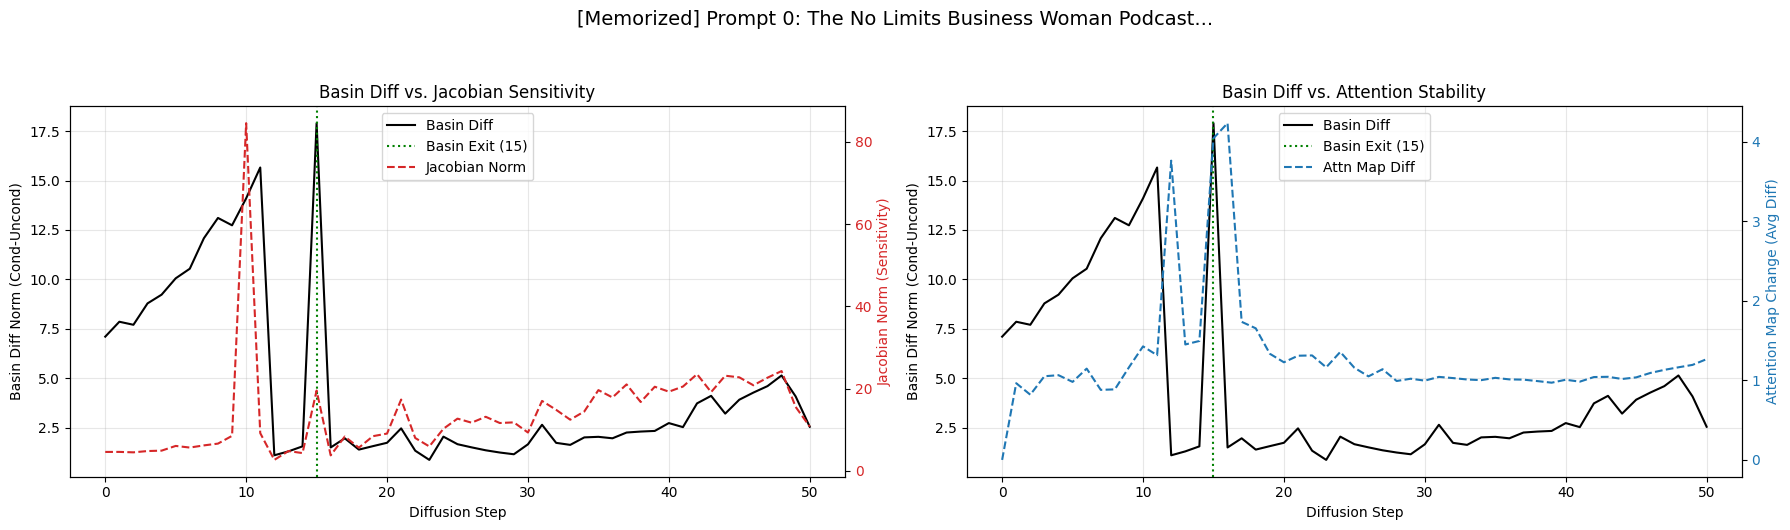

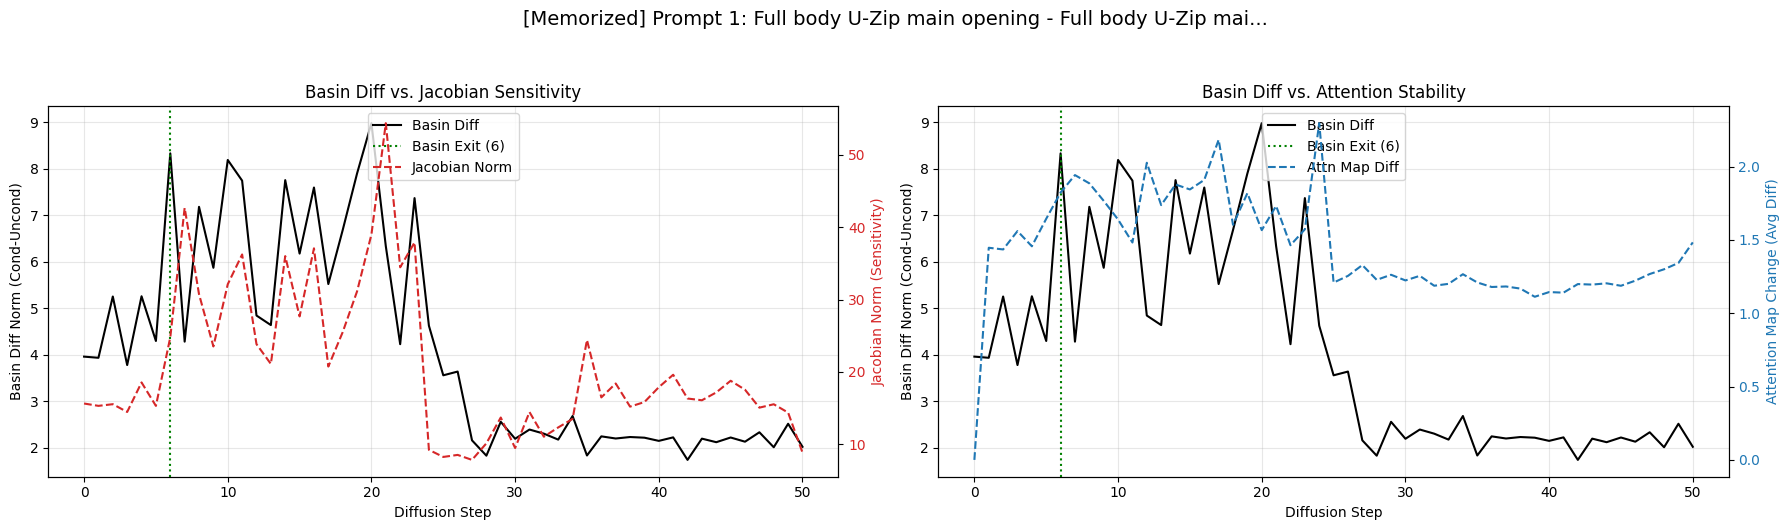

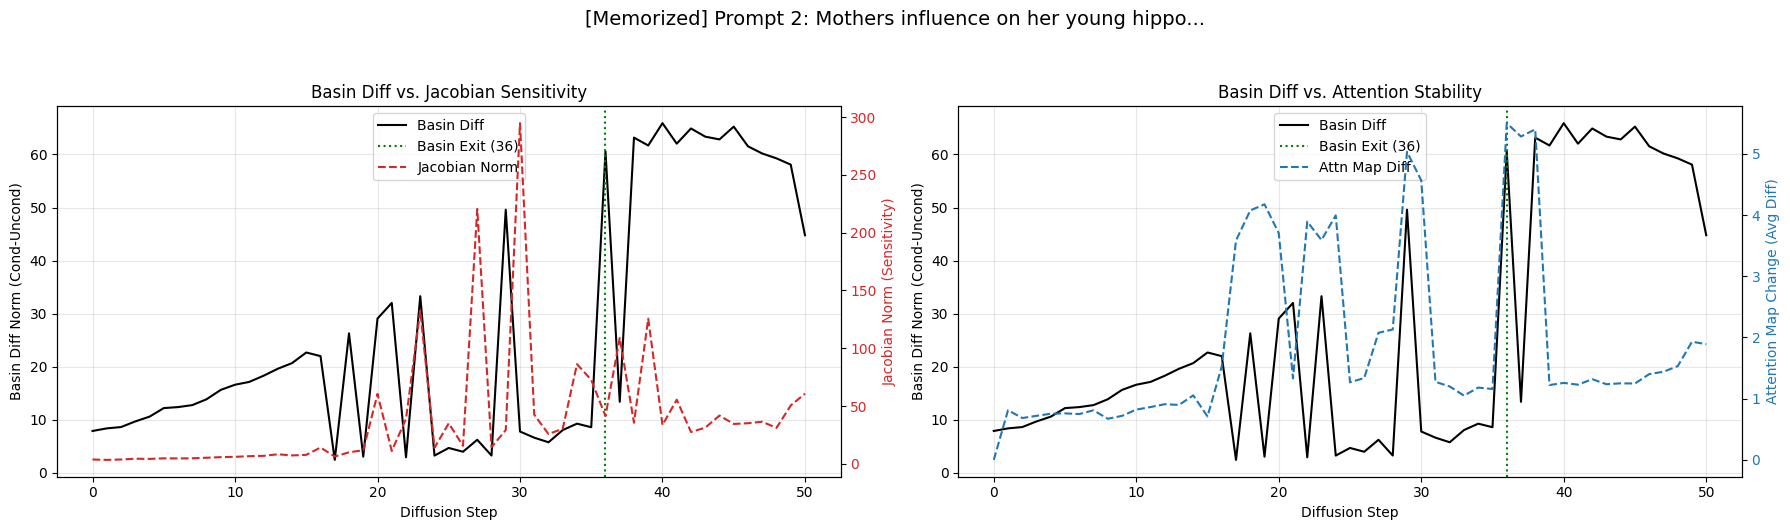

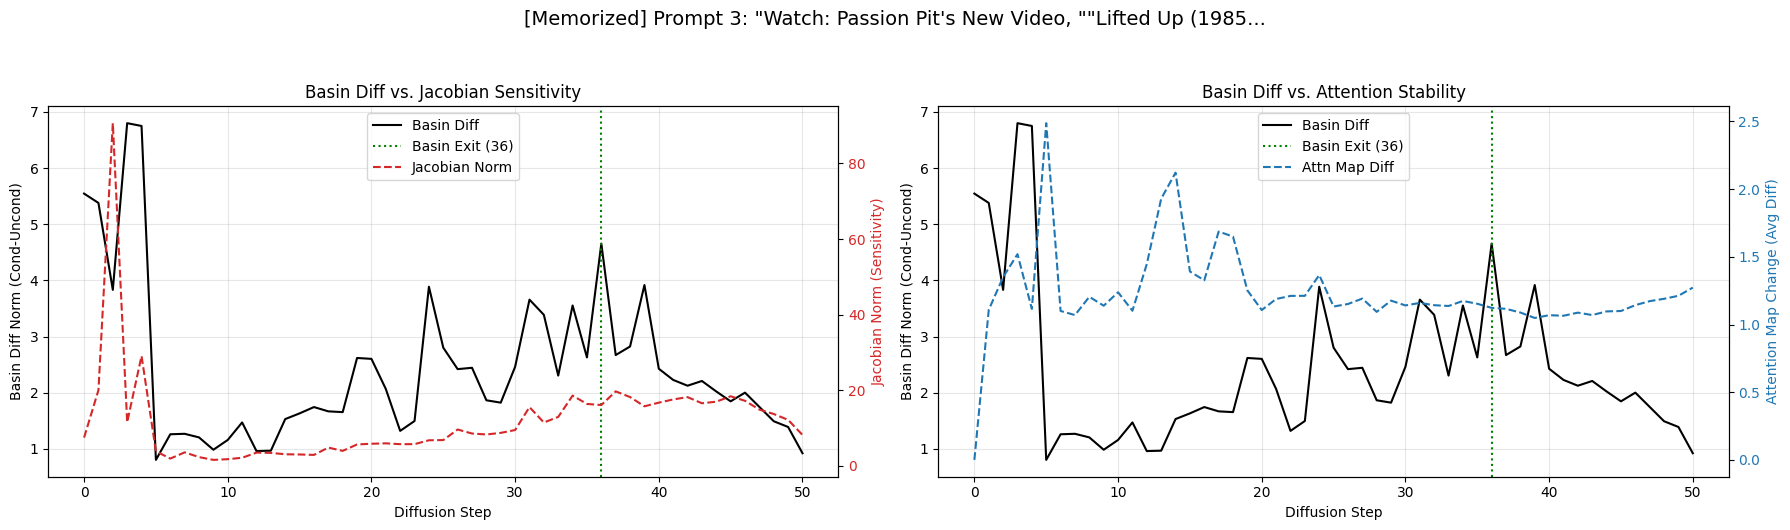

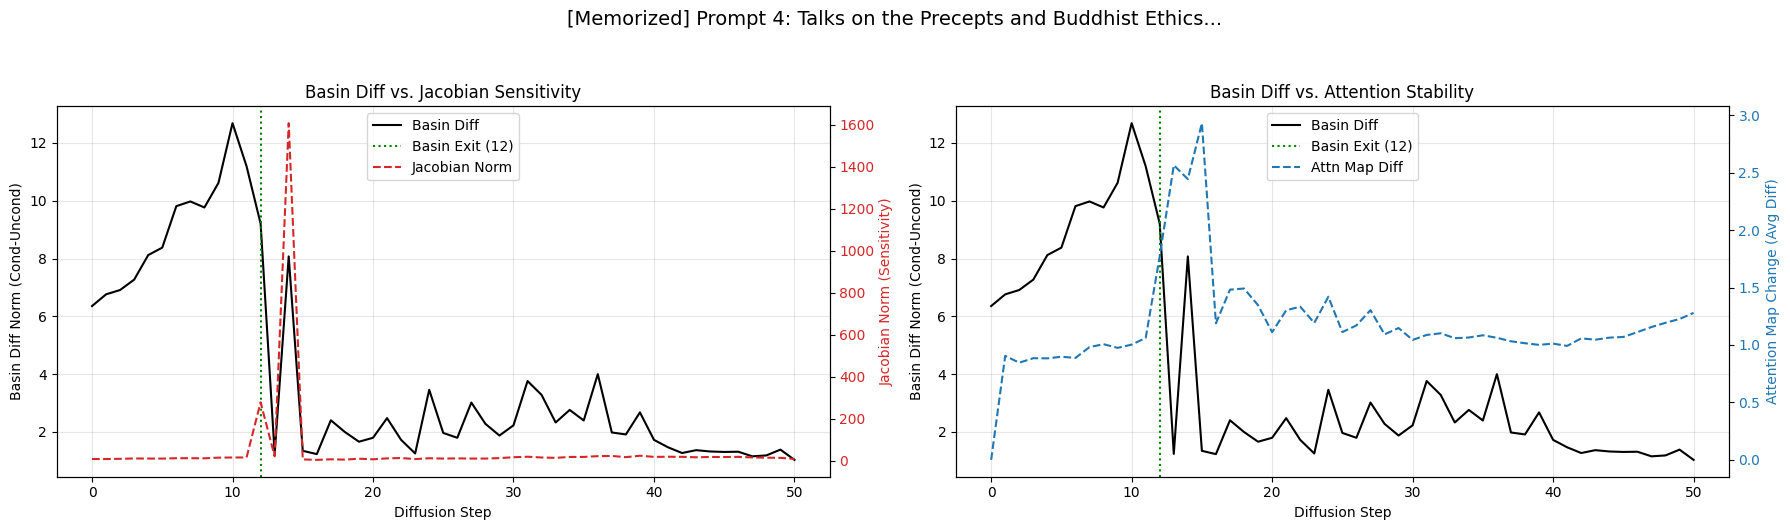

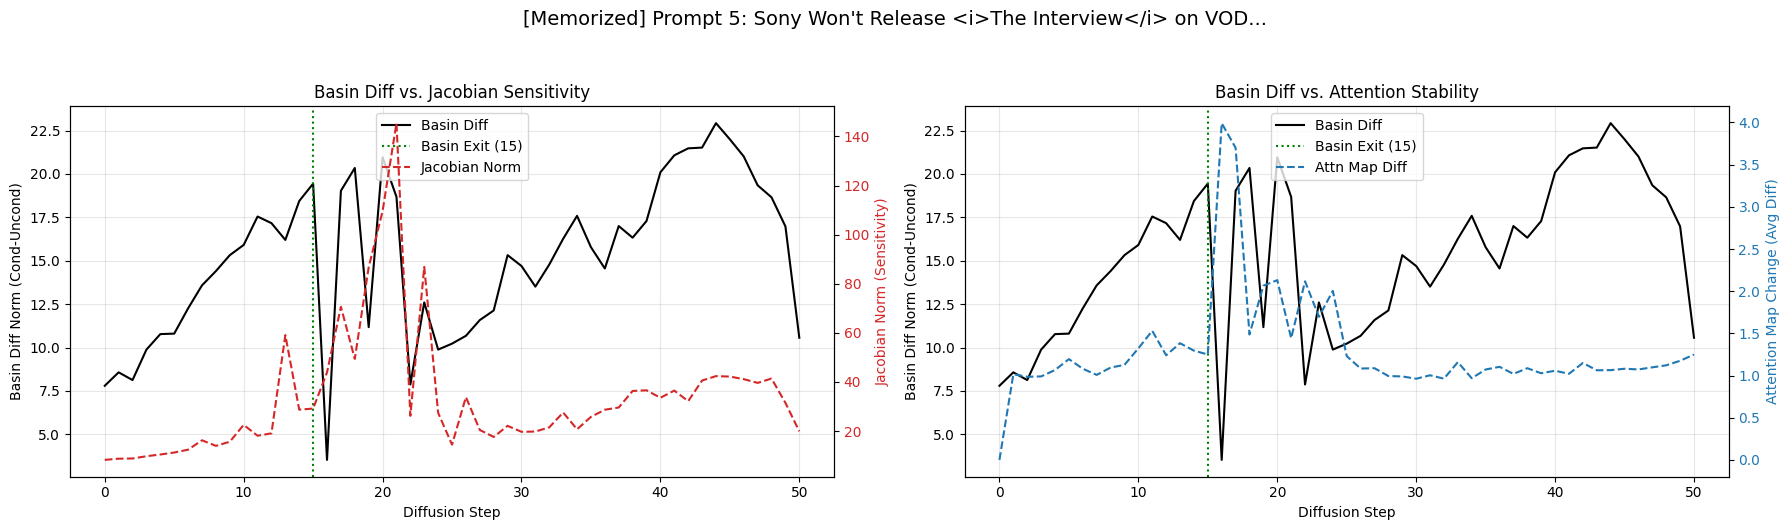

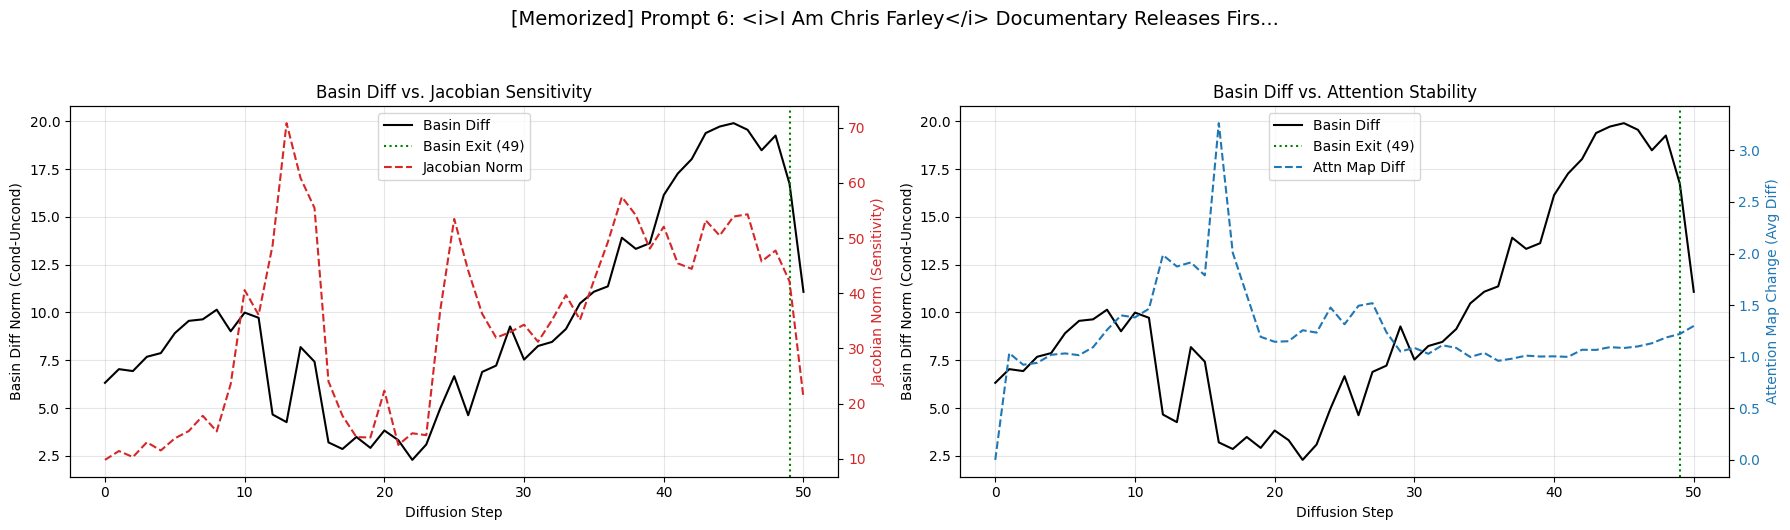

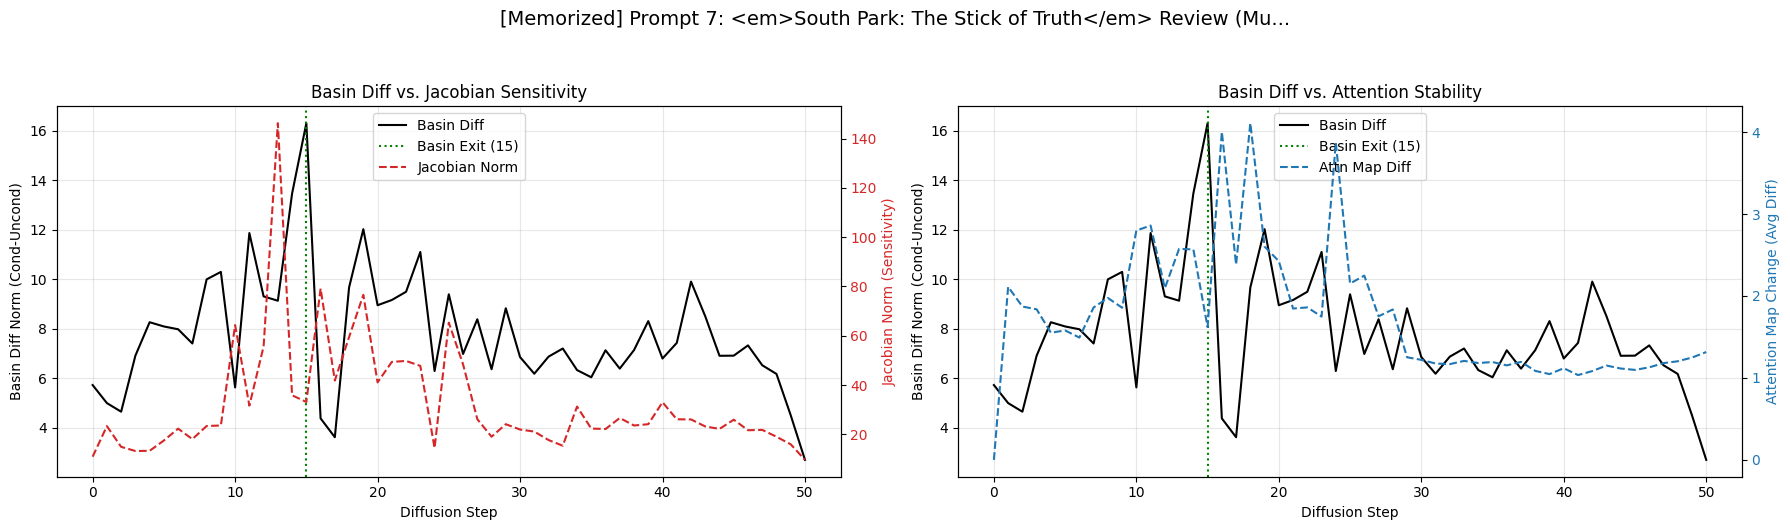

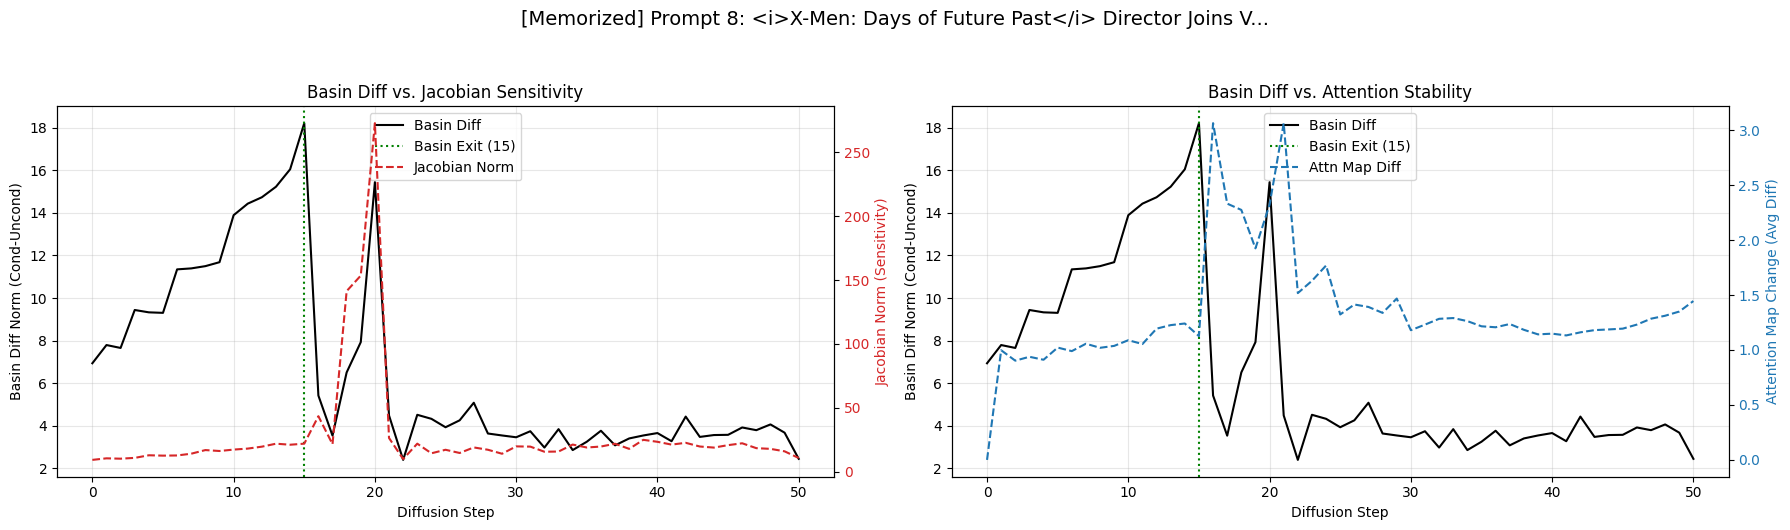

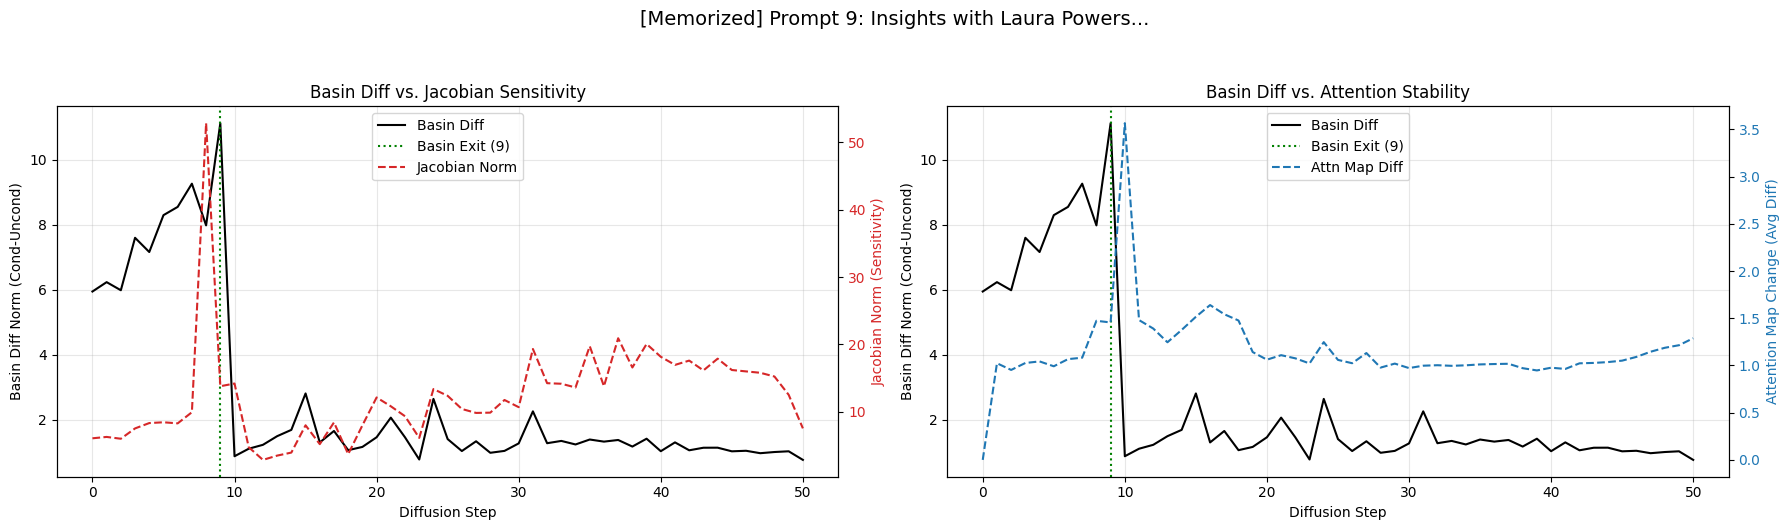

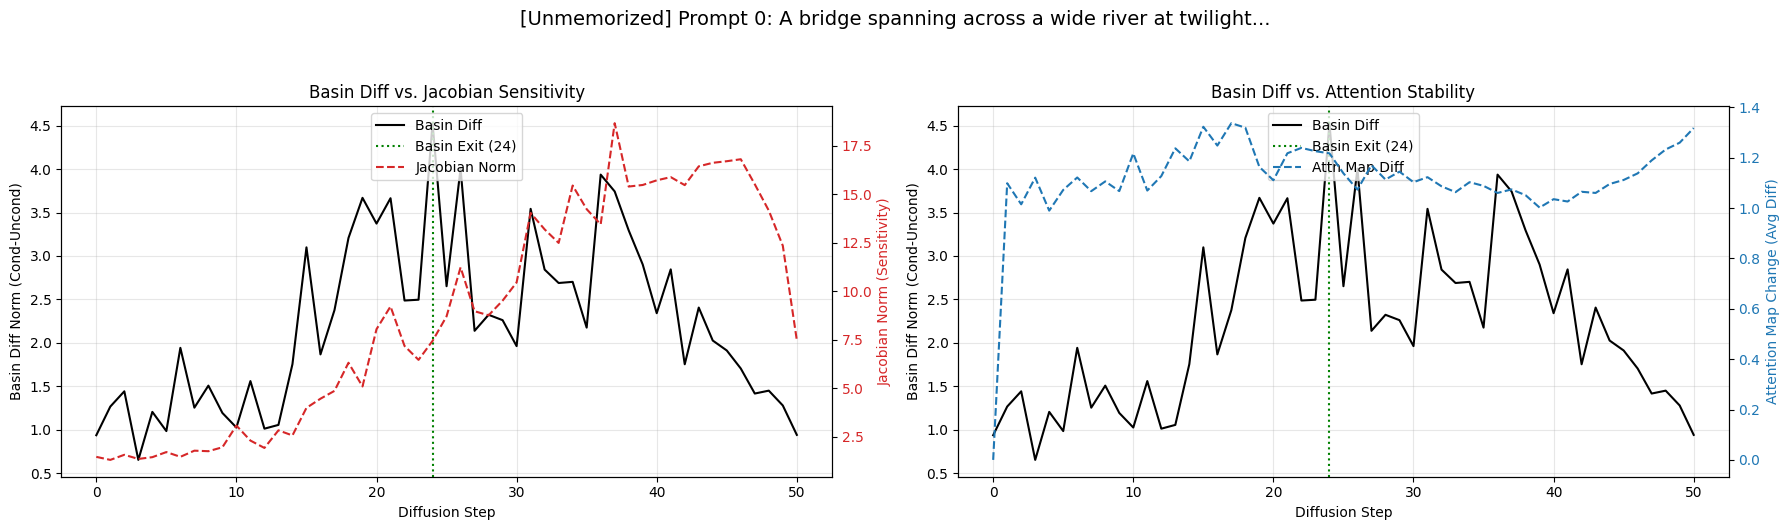

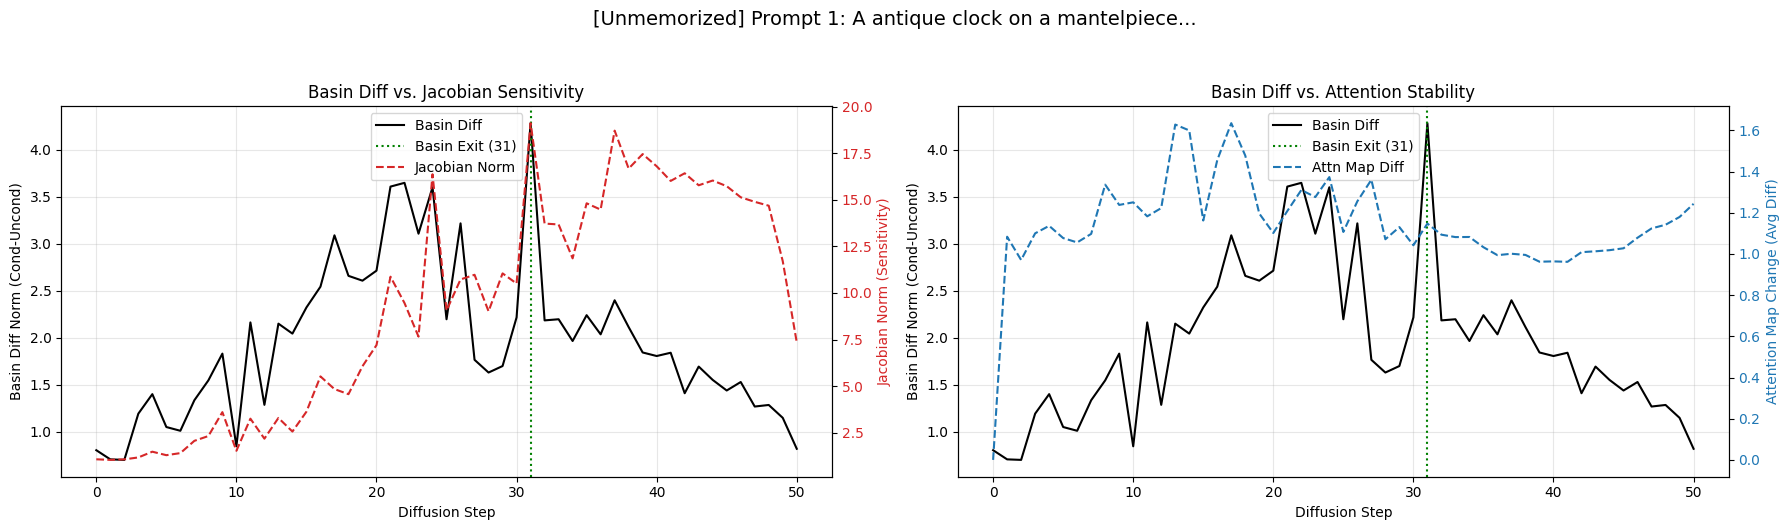

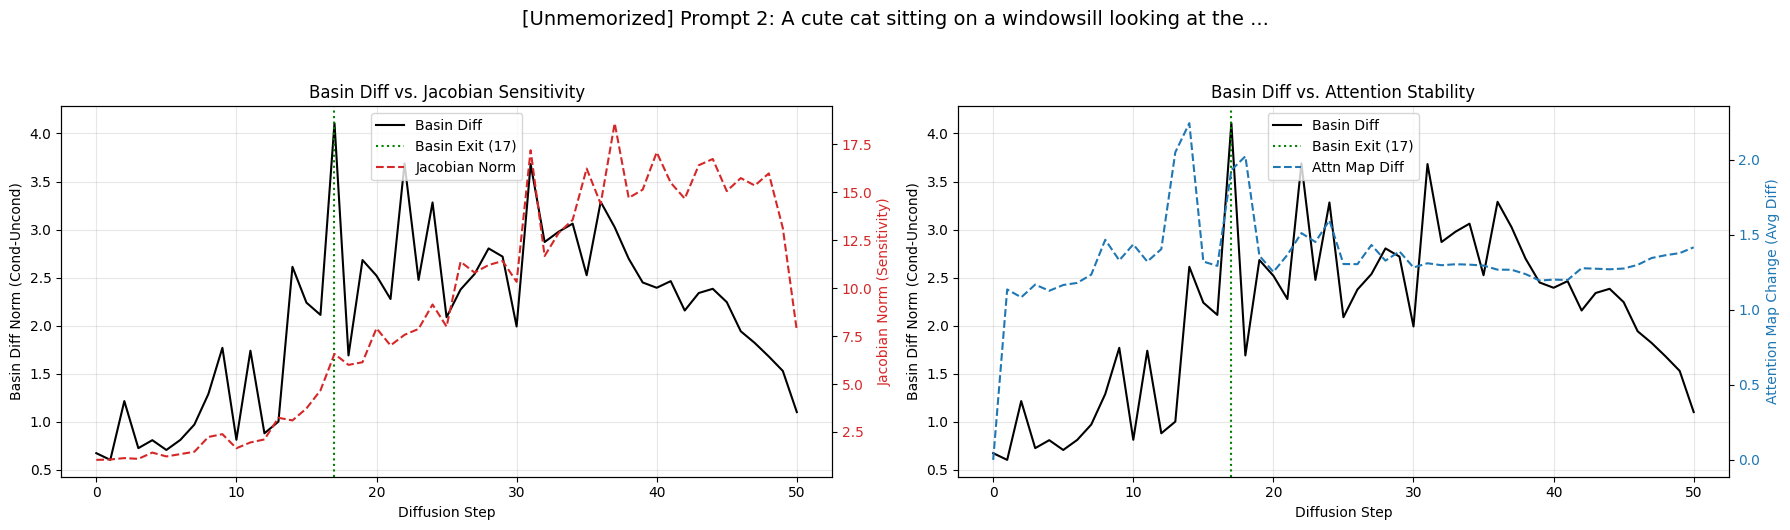

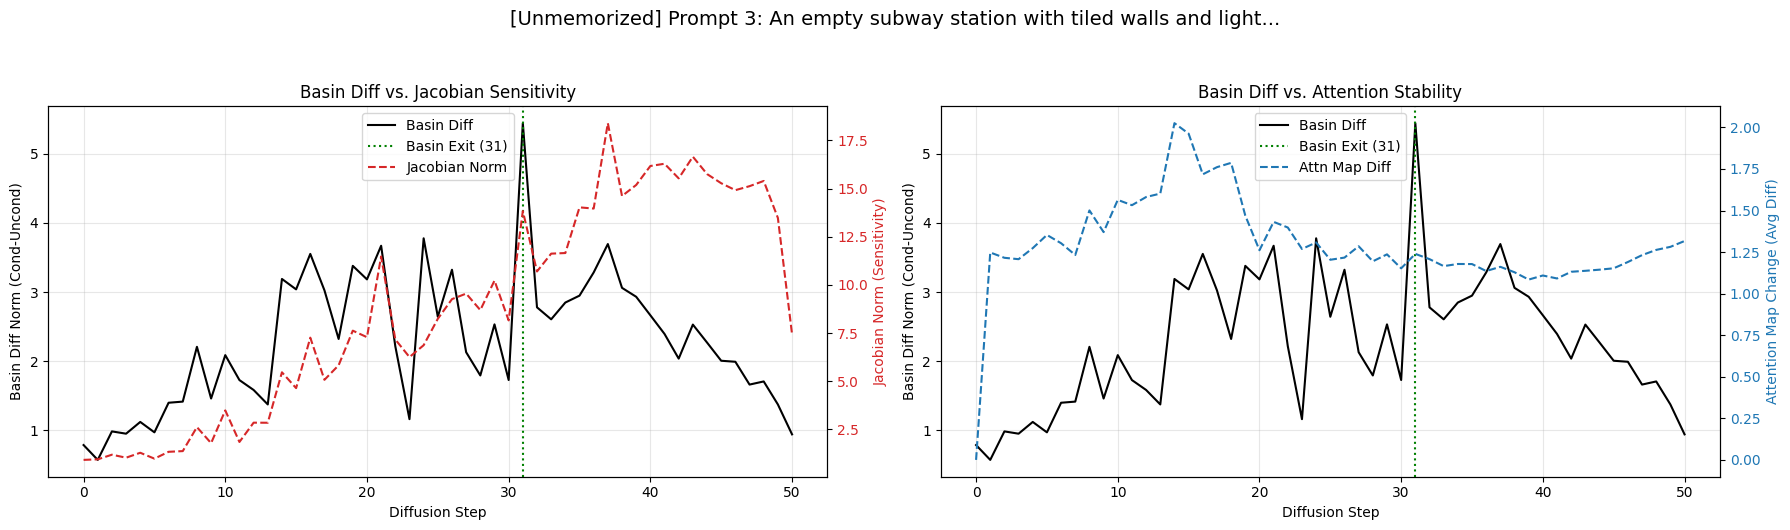

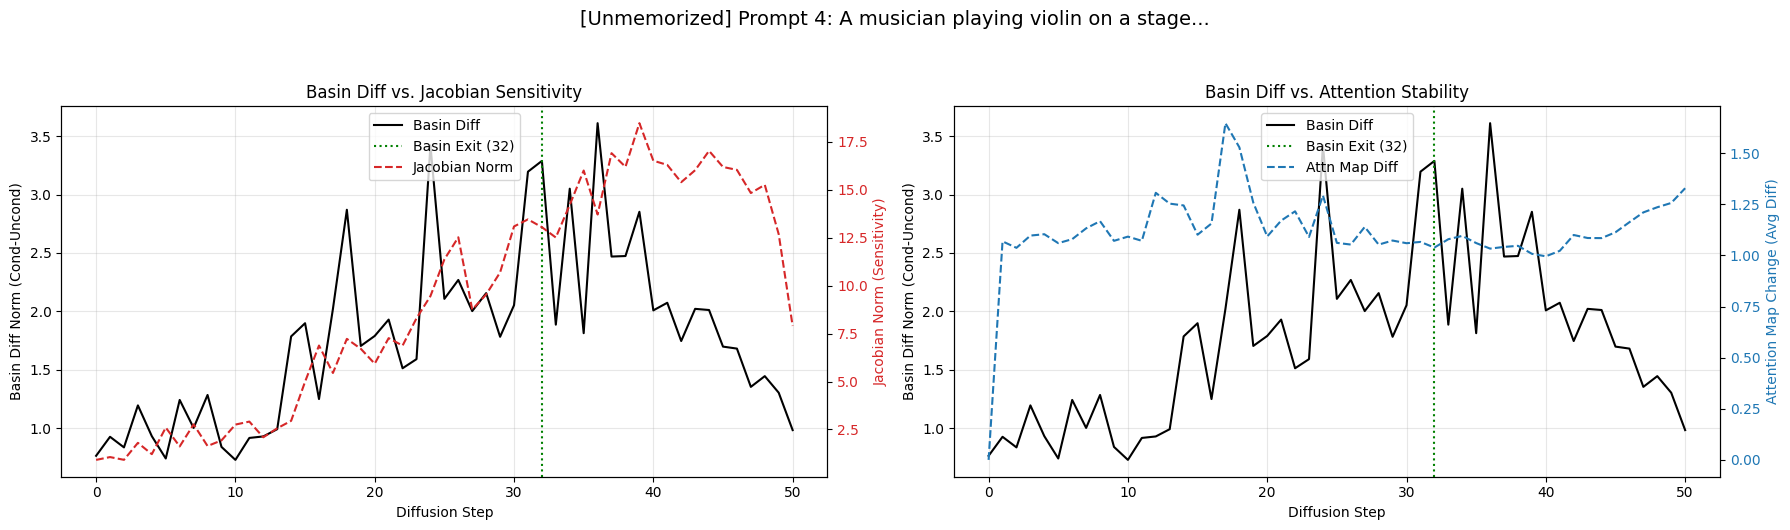

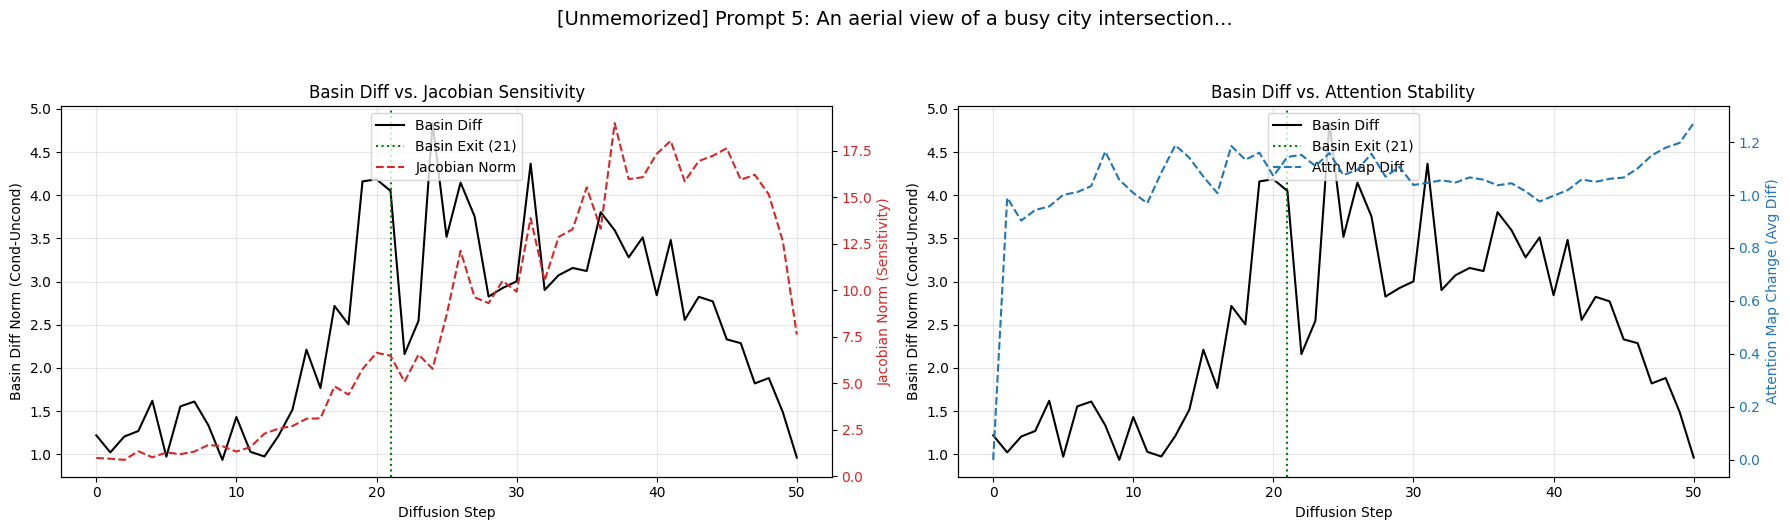

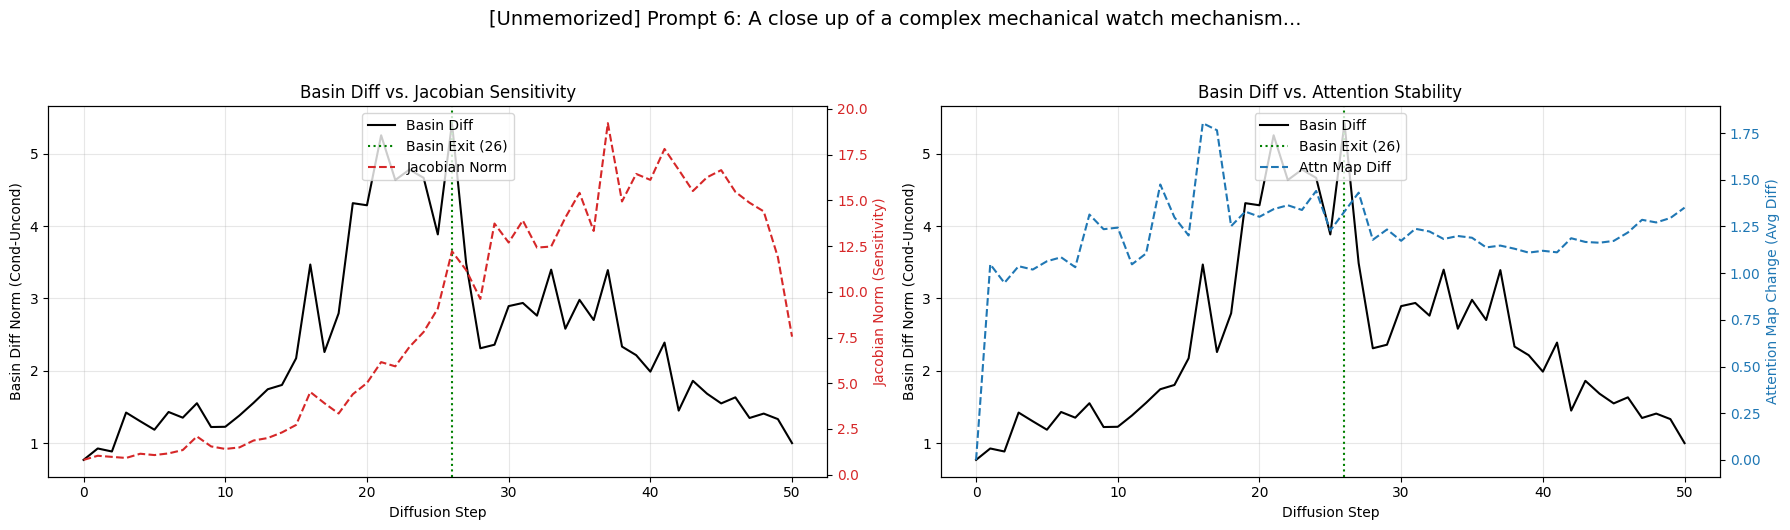

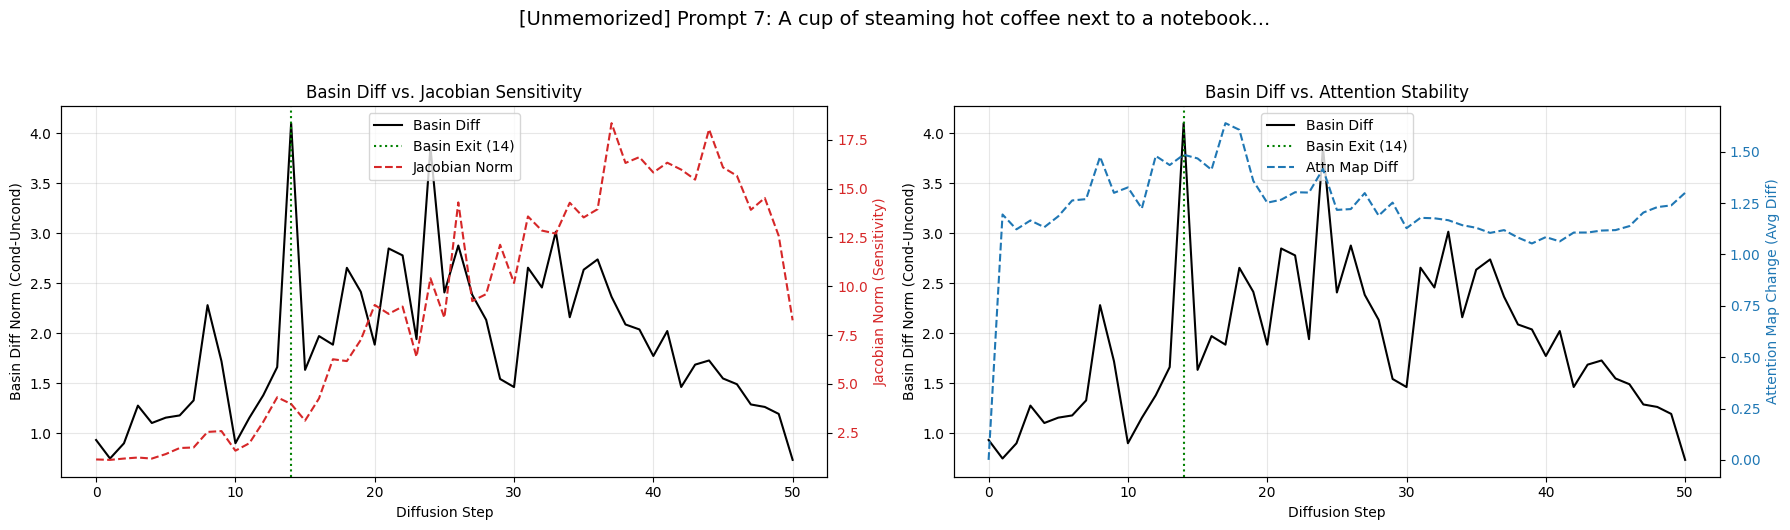

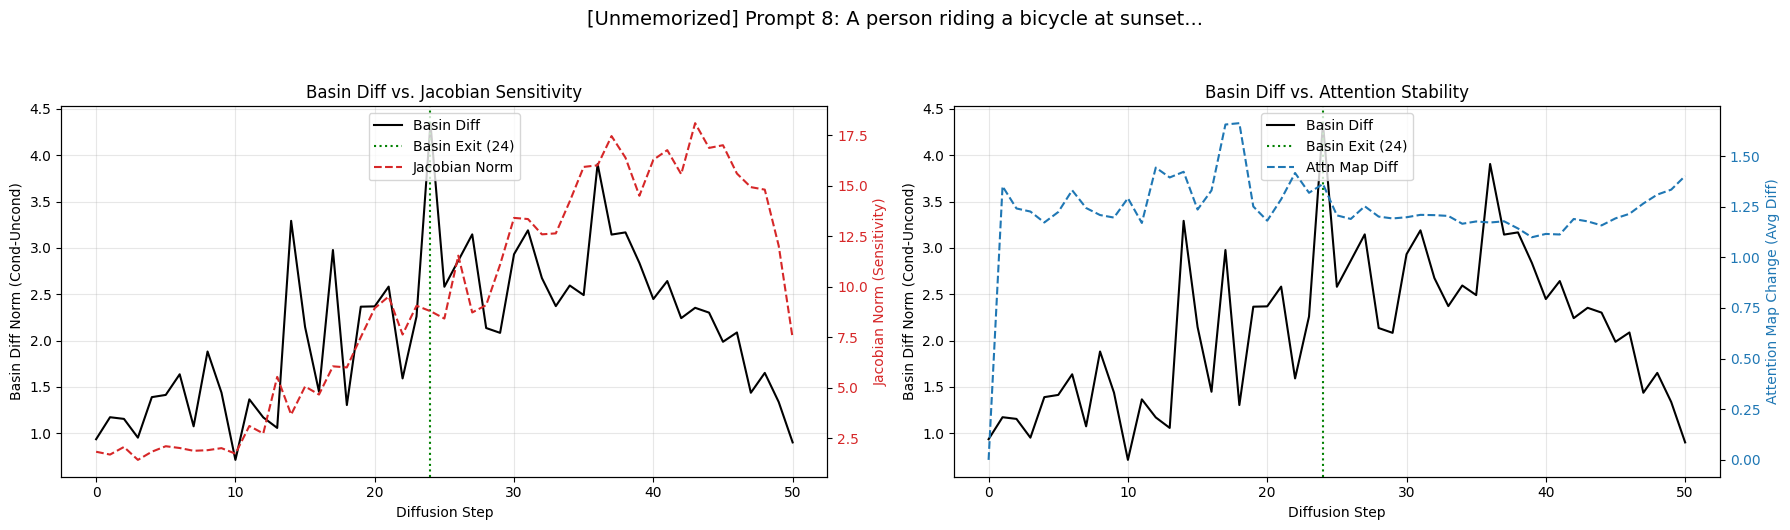

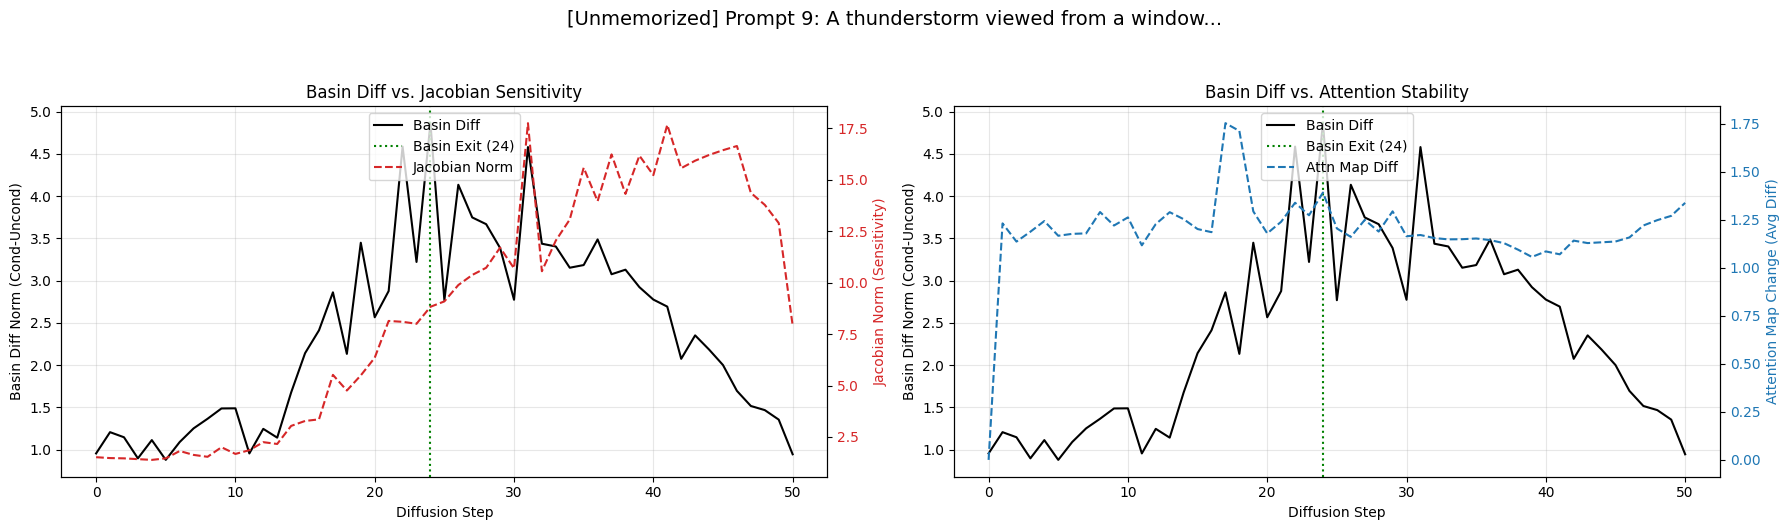

In [28]:
import matplotlib.pyplot as plt

def visualize_combined_dynamics(results, title_prefix=""):
    """
    Visualizes Diff Norm vs Jacobian and Diff Norm vs Attention for each prompt.
    """
    n_samples = len(results)
    
    for i, res in enumerate(results):
        prompt = res['Prompt']
        curve = res['Curve']                # Diff Norm
        j_curve = res['Jacobian_Curve']     # Jacobian Norm
        a_curve = res['Attn_Diff_Curve']    # Attn Map Diff
        drop_idx = res['Drop_Index']
        
        # Create 2 Subplots per prompt
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
        
        # --- Plot 1: Diff Norm vs Jacobian Norm ---
        color = 'black'
        ax1.set_xlabel('Diffusion Step')
        ax1.set_ylabel('Basin Diff Norm (Cond-Uncond)', color=color)
        ax1.plot(curve, color=color, label='Basin Diff')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.grid(True, alpha=0.3)
        
        # Twin Axis for Jacobian
        ax1_twin = ax1.twinx()
        color = 'tab:red'
        ax1_twin.set_ylabel('Jacobian Norm (Sensitivity)', color=color)
        ax1_twin.plot(j_curve, color=color, linestyle='--', label='Jacobian Norm')
        ax1_twin.tick_params(axis='y', labelcolor=color)
        
        # Basin Exit Line
        ax1.axvline(drop_idx, color='green', linestyle=':', label=f'Basin Exit ({drop_idx})')
        
        # Legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1_twin.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')
        ax1.set_title("Basin Diff vs. Jacobian Sensitivity")
        
        
        # --- Plot 2: Diff Norm vs Attention Stability ---
        color = 'black'
        ax2.set_xlabel('Diffusion Step')
        ax2.set_ylabel('Basin Diff Norm (Cond-Uncond)', color=color)
        ax2.plot(curve, color=color, label='Basin Diff')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.grid(True, alpha=0.3)
        
        # Twin Axis for Attention
        ax2_twin = ax2.twinx()
        color = 'tab:blue'
        ax2_twin.set_ylabel('Attention Map Change (Avg Diff)', color=color)
        ax2_twin.plot(a_curve, color=color, linestyle='--', label='Attn Map Diff')
        ax2_twin.tick_params(axis='y', labelcolor=color)
        
        # Basin Exit Line
        ax2.axvline(drop_idx, color='green', linestyle=':', label=f'Basin Exit ({drop_idx})')
        
        # Legend
        lines3, labels3 = ax2.get_legend_handles_labels()
        lines4, labels4 = ax2_twin.get_legend_handles_labels()
        ax2.legend(lines3 + lines4, labels3 + labels4, loc='upper center')
        ax2.set_title("Basin Diff vs. Attention Stability")
        
        plt.suptitle(f"[{title_prefix}] Prompt {i}: {prompt[:50]}...", fontsize=14, y=1.05)
        plt.tight_layout()
        plt.show()

# Run Visualization
visualize_combined_dynamics(pure_mem_results, "Memorized")
visualize_combined_dynamics(pure_unmem_results, "Unmemorized")